In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# genes

In [2]:
def get_data(healthy):
    healthy_str = "" if healthy else "_SZ"
    peaks = pd.read_csv(
        f"../../data/input/new{healthy_str}_ourRNA-35reg-prot_genes-peaks.txt", sep="\t")
    meta = pd.read_csv(
        f"../../data/input/new{healthy_str}_ourRNA-35reg-prot_genes-data.txt", sep="\t", header=None)
    data = pd.merge(meta[[1, 5, 7]], peaks.T.reset_index(), left_on=1, right_on="index")
    data = data.rename(columns={1: "batch", 5: "human", 7: "region"}).drop(columns=["index"])
    data = data.set_index("human")
    data = data.sort_values(["human", "region"])
    data.region = data.region.str.replace(u'\xa0', ' ')
    return data

In [3]:
healthy_data = get_data(True)
sz_data = get_data(False)

In [4]:
pca = PCA(n_components=2, random_state=2093487)

In [5]:
annotations = ["HA", "HB", "HC", "HD", "H1", "H2", "H3", "H5"]

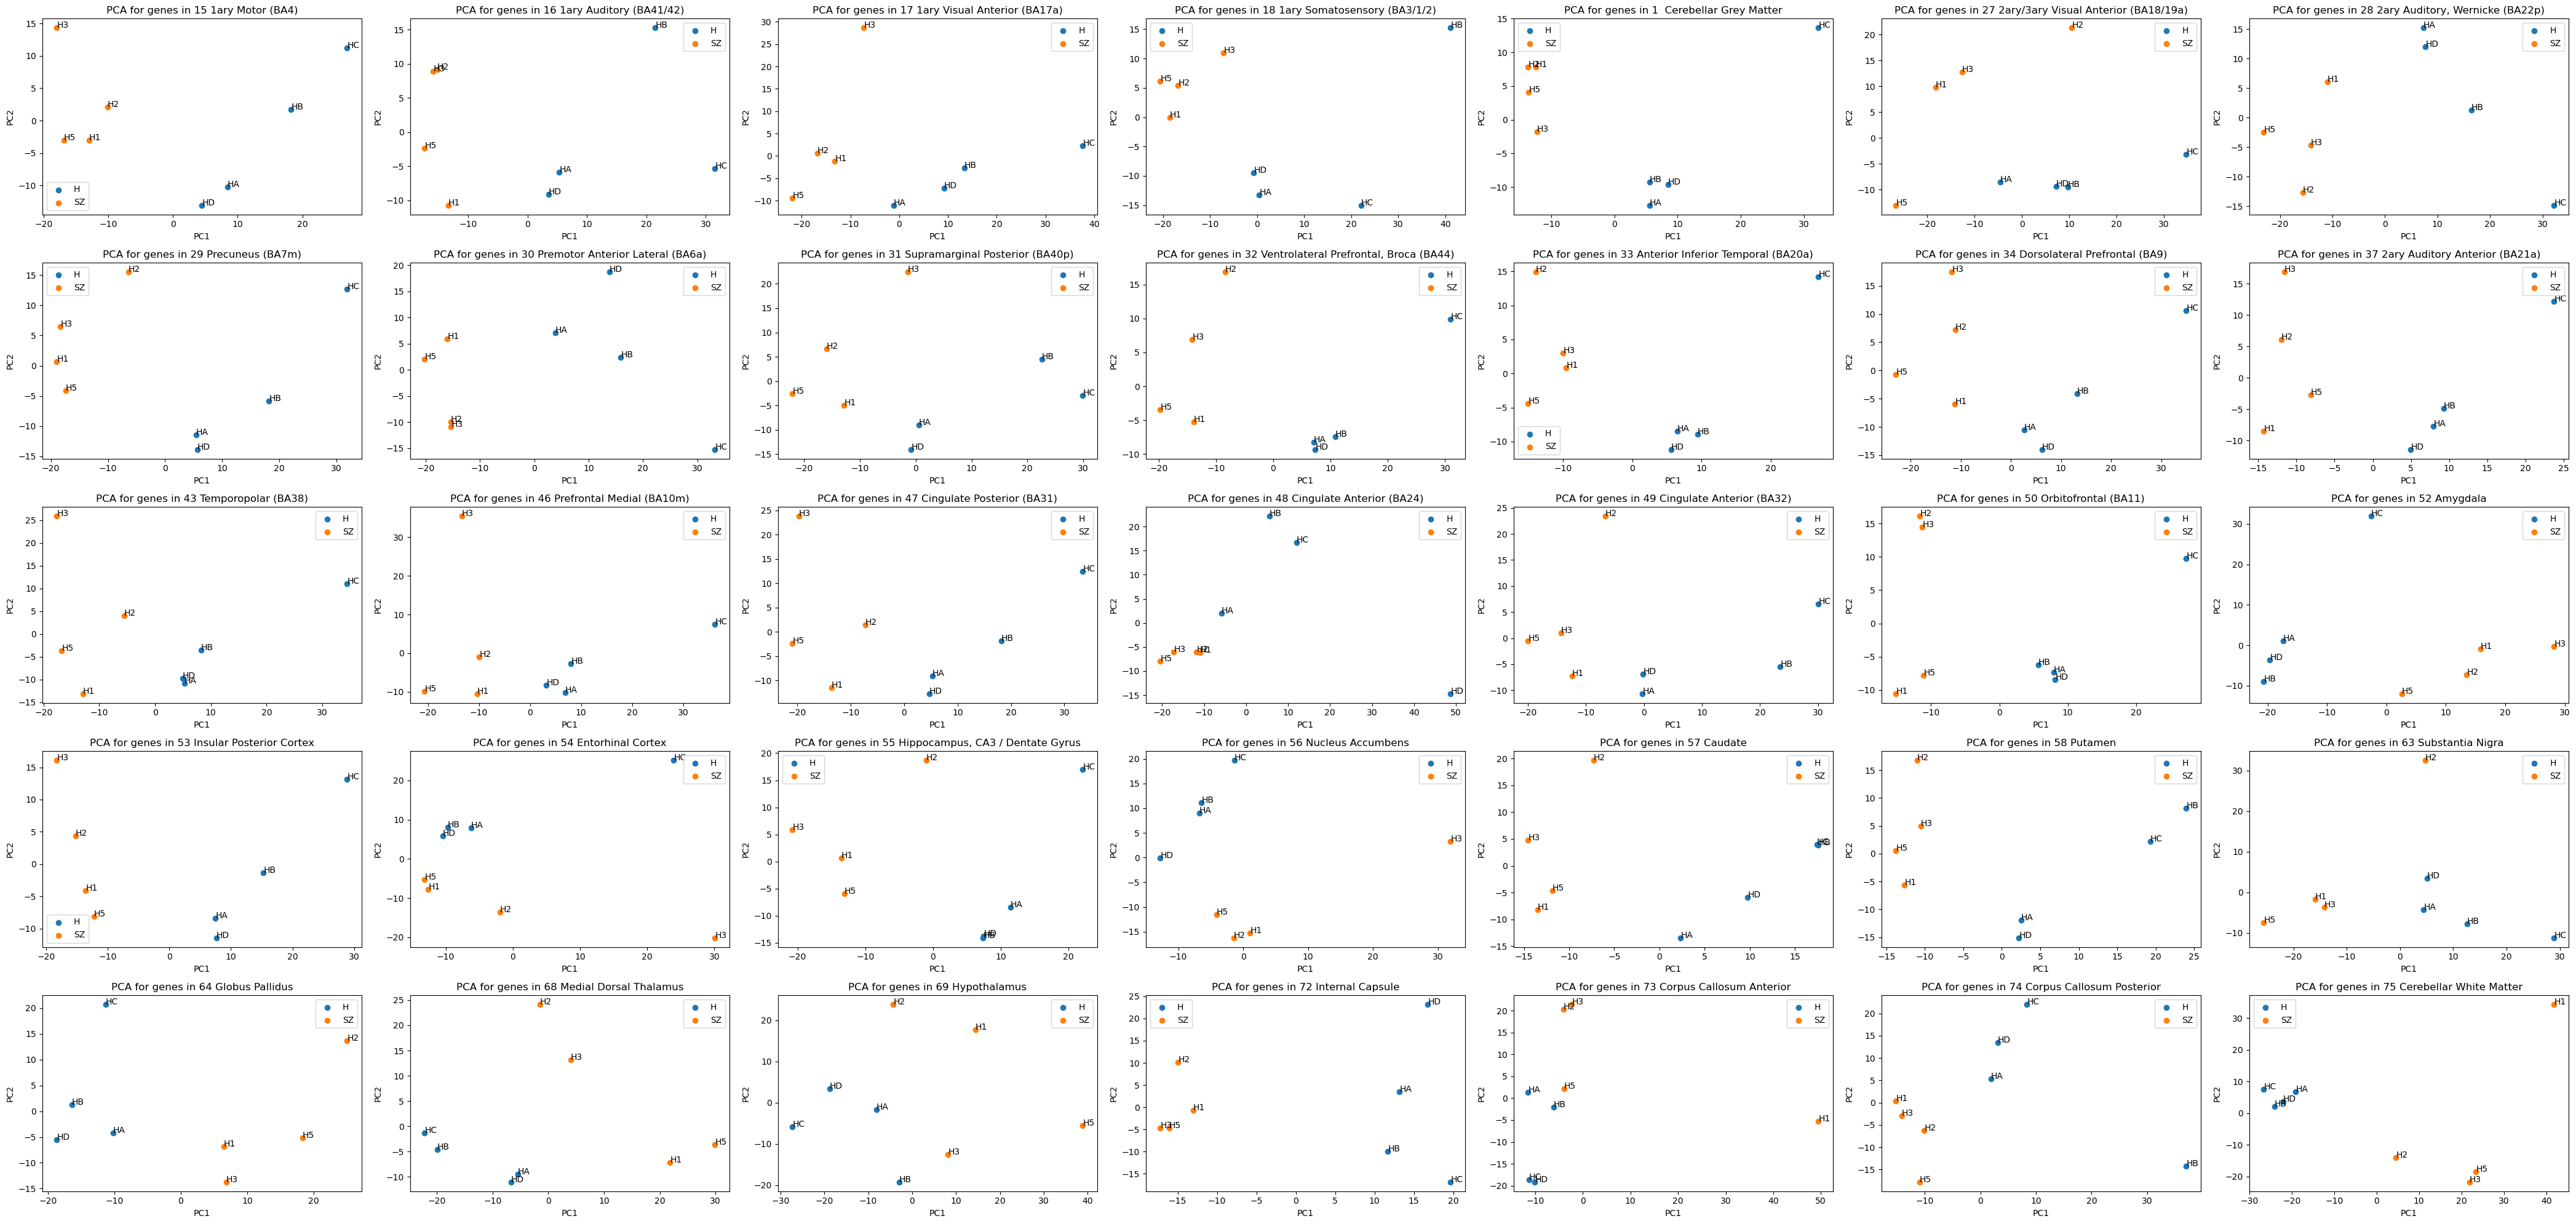

In [6]:
nrows = 5
ncols = 7
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*4))
axs = axs.flatten()
for i, region_nm in enumerate(sz_data.region.unique()):
    ax = axs[i]
    h_region = healthy_data[healthy_data.region == region_nm].drop(columns=["batch", "region"])
    sz_region = sz_data[sz_data.region == region_nm].drop(columns=["batch", "region"])

    pca_data = pca.fit_transform(pd.concat([h_region, sz_region]).dropna(axis=1))

    ax.scatter(pca_data[:4, 0], pca_data[:4, 1], label="H")
    ax.scatter(pca_data[4:, 0], pca_data[4:, 1], label="SZ")
    
    for i in range(len(pca_data)):
        ax.annotate(annotations[i], (pca_data[i, 0], pca_data[i, 1]))
    
    ax.set_title(f"PCA for genes in {region_nm}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.legend()
plt.tight_layout()    
# plt.savefig("../../data/intermediate/pics/fig1.pdf", dpi=200)    

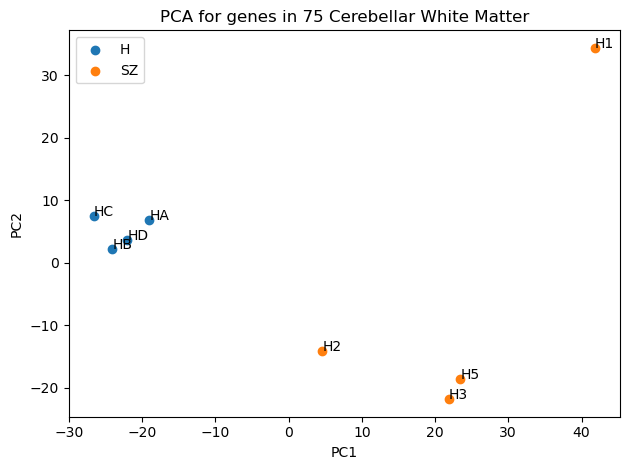

In [8]:
plt.scatter(pca_data[:4, 0], pca_data[:4, 1], label="H")
plt.scatter(pca_data[4:, 0], pca_data[4:, 1], label="SZ")

for i in range(len(pca_data)):
    plt.annotate(annotations[i], (pca_data[i, 0], pca_data[i, 1]))

plt.title(f"PCA for genes in {region_nm}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()    
plt.savefig("../../data/intermediate/pics/genes_pca.pdf", dpi=200)

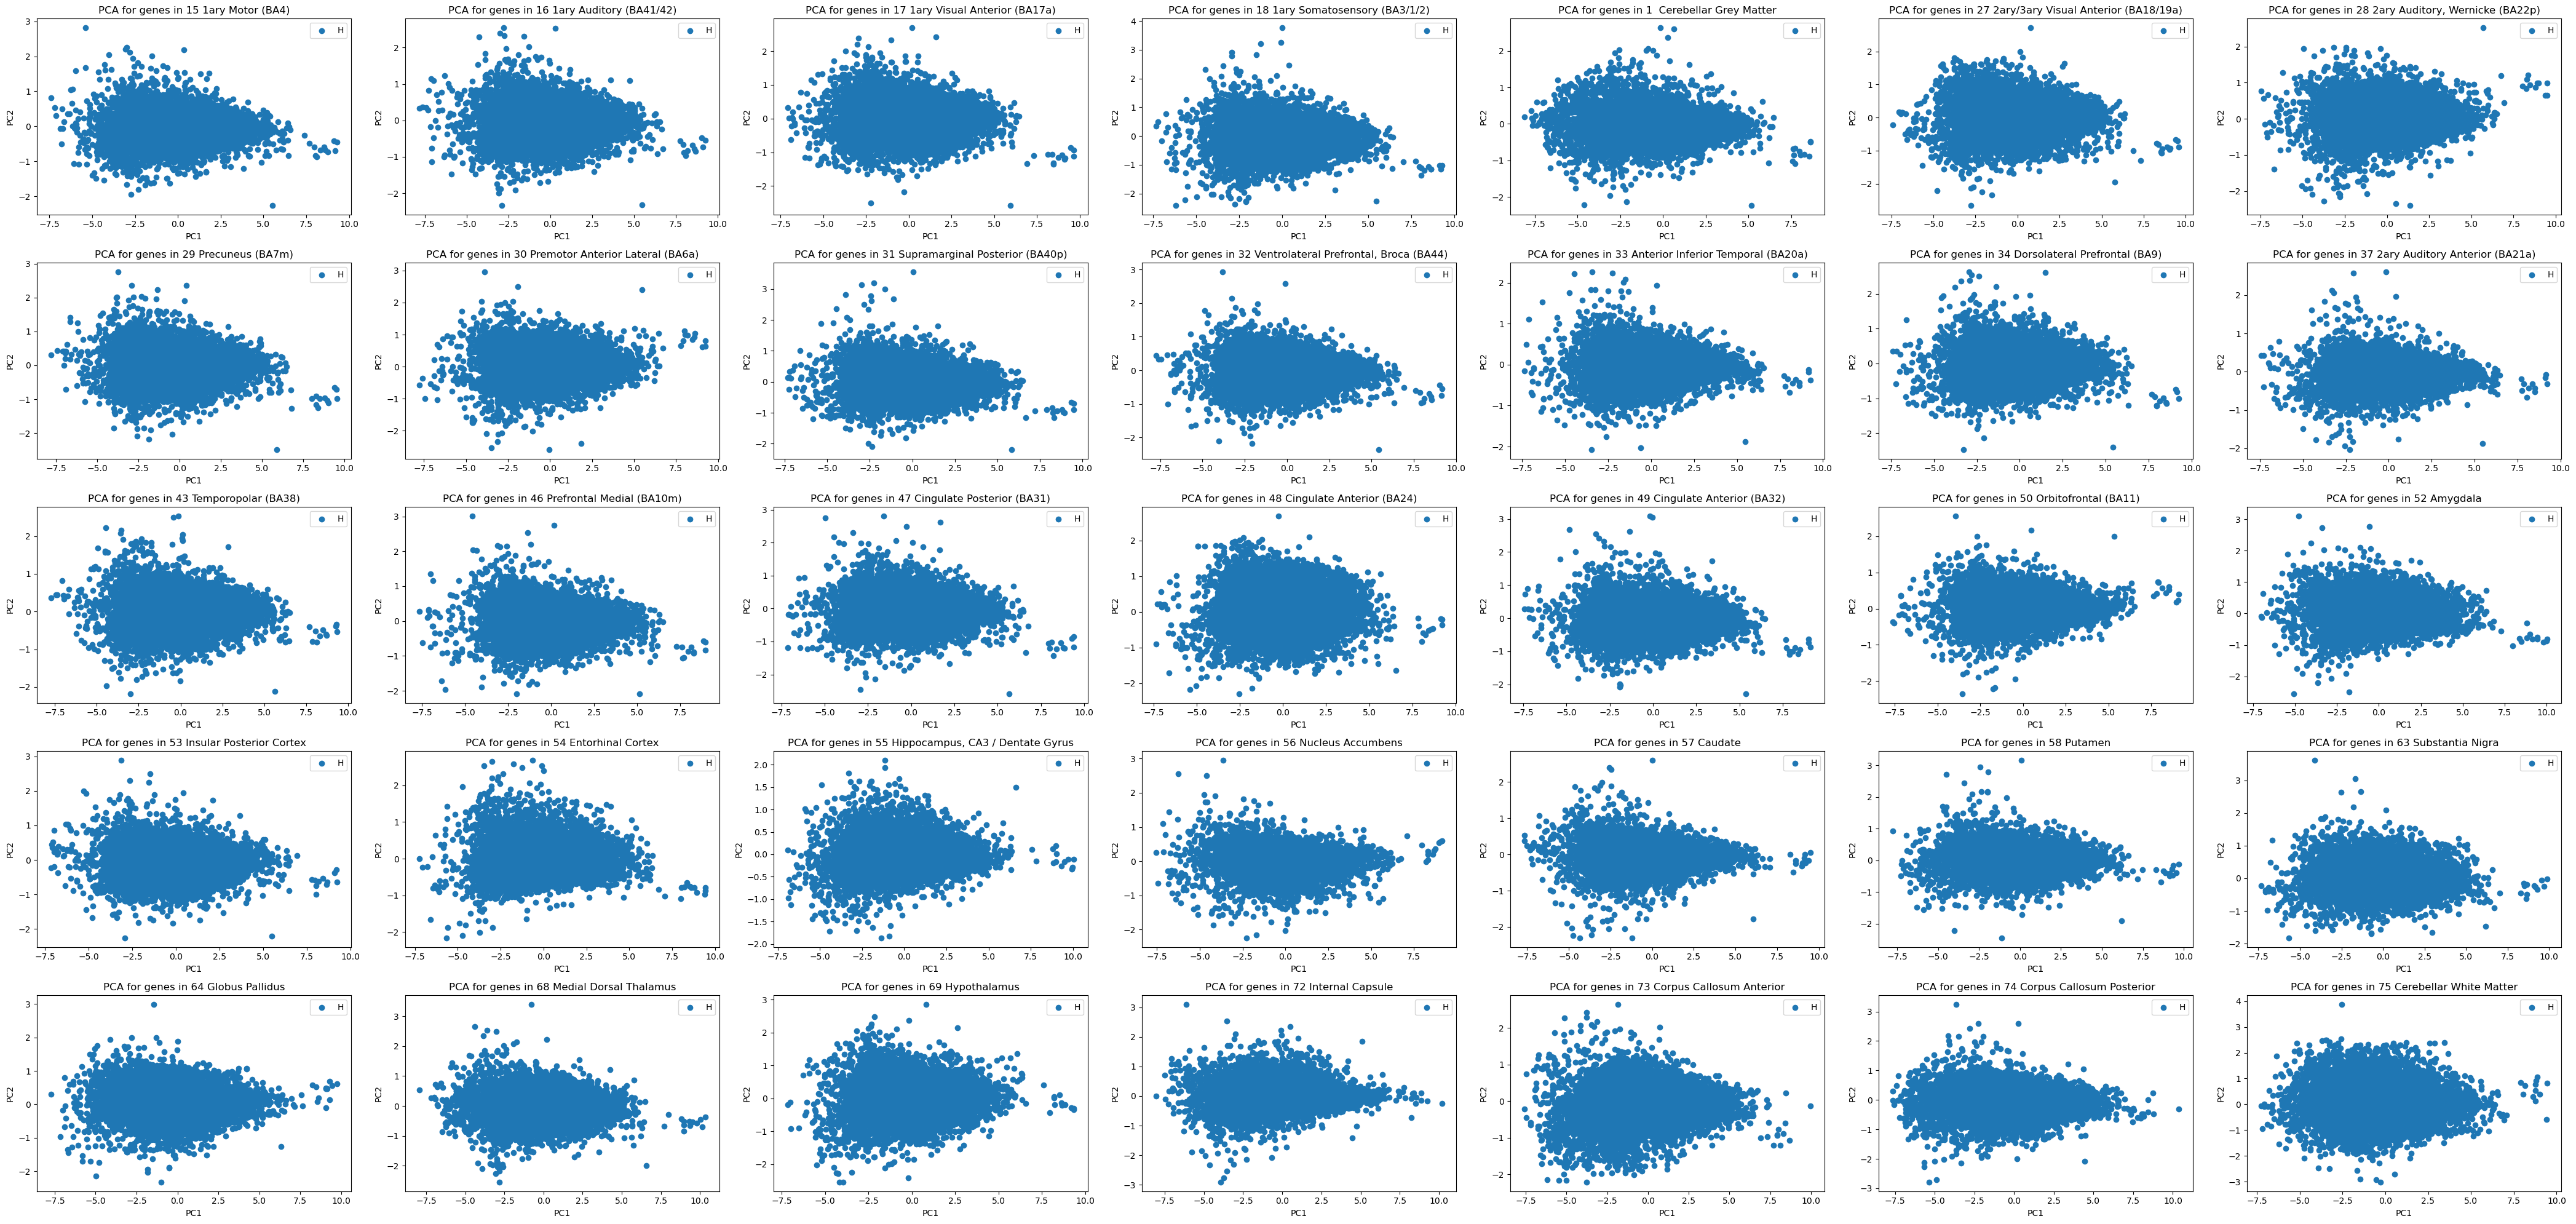

In [11]:
nrows = 5
ncols = 7
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*4))
axs = axs.flatten()
for i, region_nm in enumerate(sz_data.region.unique()):
    ax = axs[i]
    h_region = healthy_data[healthy_data.region == region_nm].drop(columns=["batch", "region"])
    sz_region = sz_data[sz_data.region == region_nm].drop(columns=["batch", "region"])

    pca_data = pca.fit_transform(pd.concat([h_region, sz_region]).dropna(axis=1).T)

    ax.scatter(pca_data[:, 0], pca_data[:, 1], label="H")
    
    ax.set_title(f"PCA for genes in {region_nm}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.legend()
plt.tight_layout()

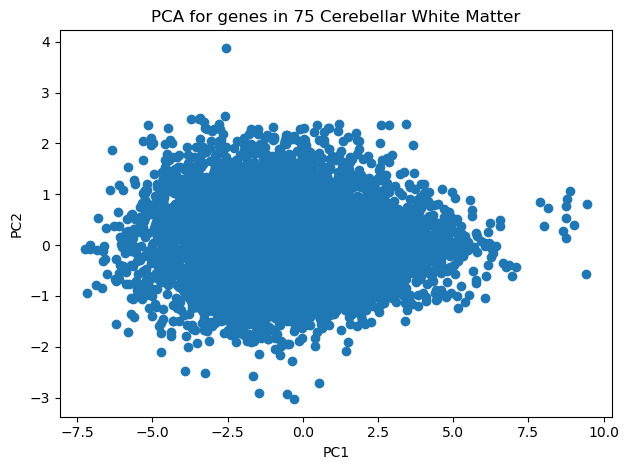

In [12]:
plt.scatter(pca_data[:, 0], pca_data[:, 1])
plt.title(f"PCA for genes in {region_nm}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()    
plt.savefig("../../data/intermediate/pics/genes_T_pca.pdf", dpi=200)    

In [13]:
tsne = TSNE(init='pca', learning_rate=100, random_state=328987432, n_jobs=-1)
h_region = healthy_data[healthy_data.region == region_nm].drop(columns=["batch", "region"])
sz_region = sz_data[sz_data.region == region_nm].drop(columns=["batch", "region"])
pca_data = tsne.fit_transform(pd.concat([h_region, sz_region]).dropna(axis=1).T)

/home/zybinmikhail/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


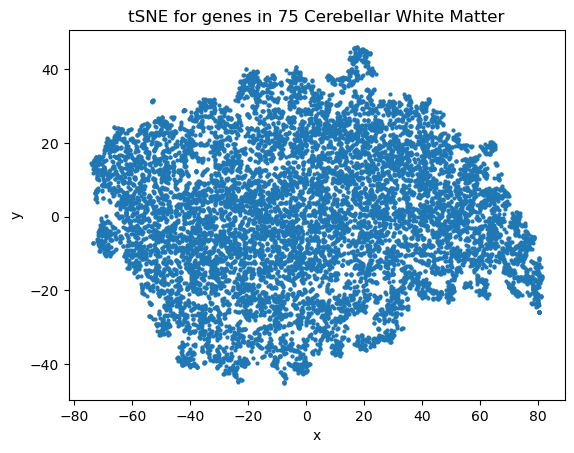

In [14]:
plt.scatter(pca_data[:, 0], pca_data[:, 1], s=2**2, label="H")
plt.title(f"tSNE for genes in {region_nm}")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("../../data/intermediate/pics/tsne.pdf", dpi=200)

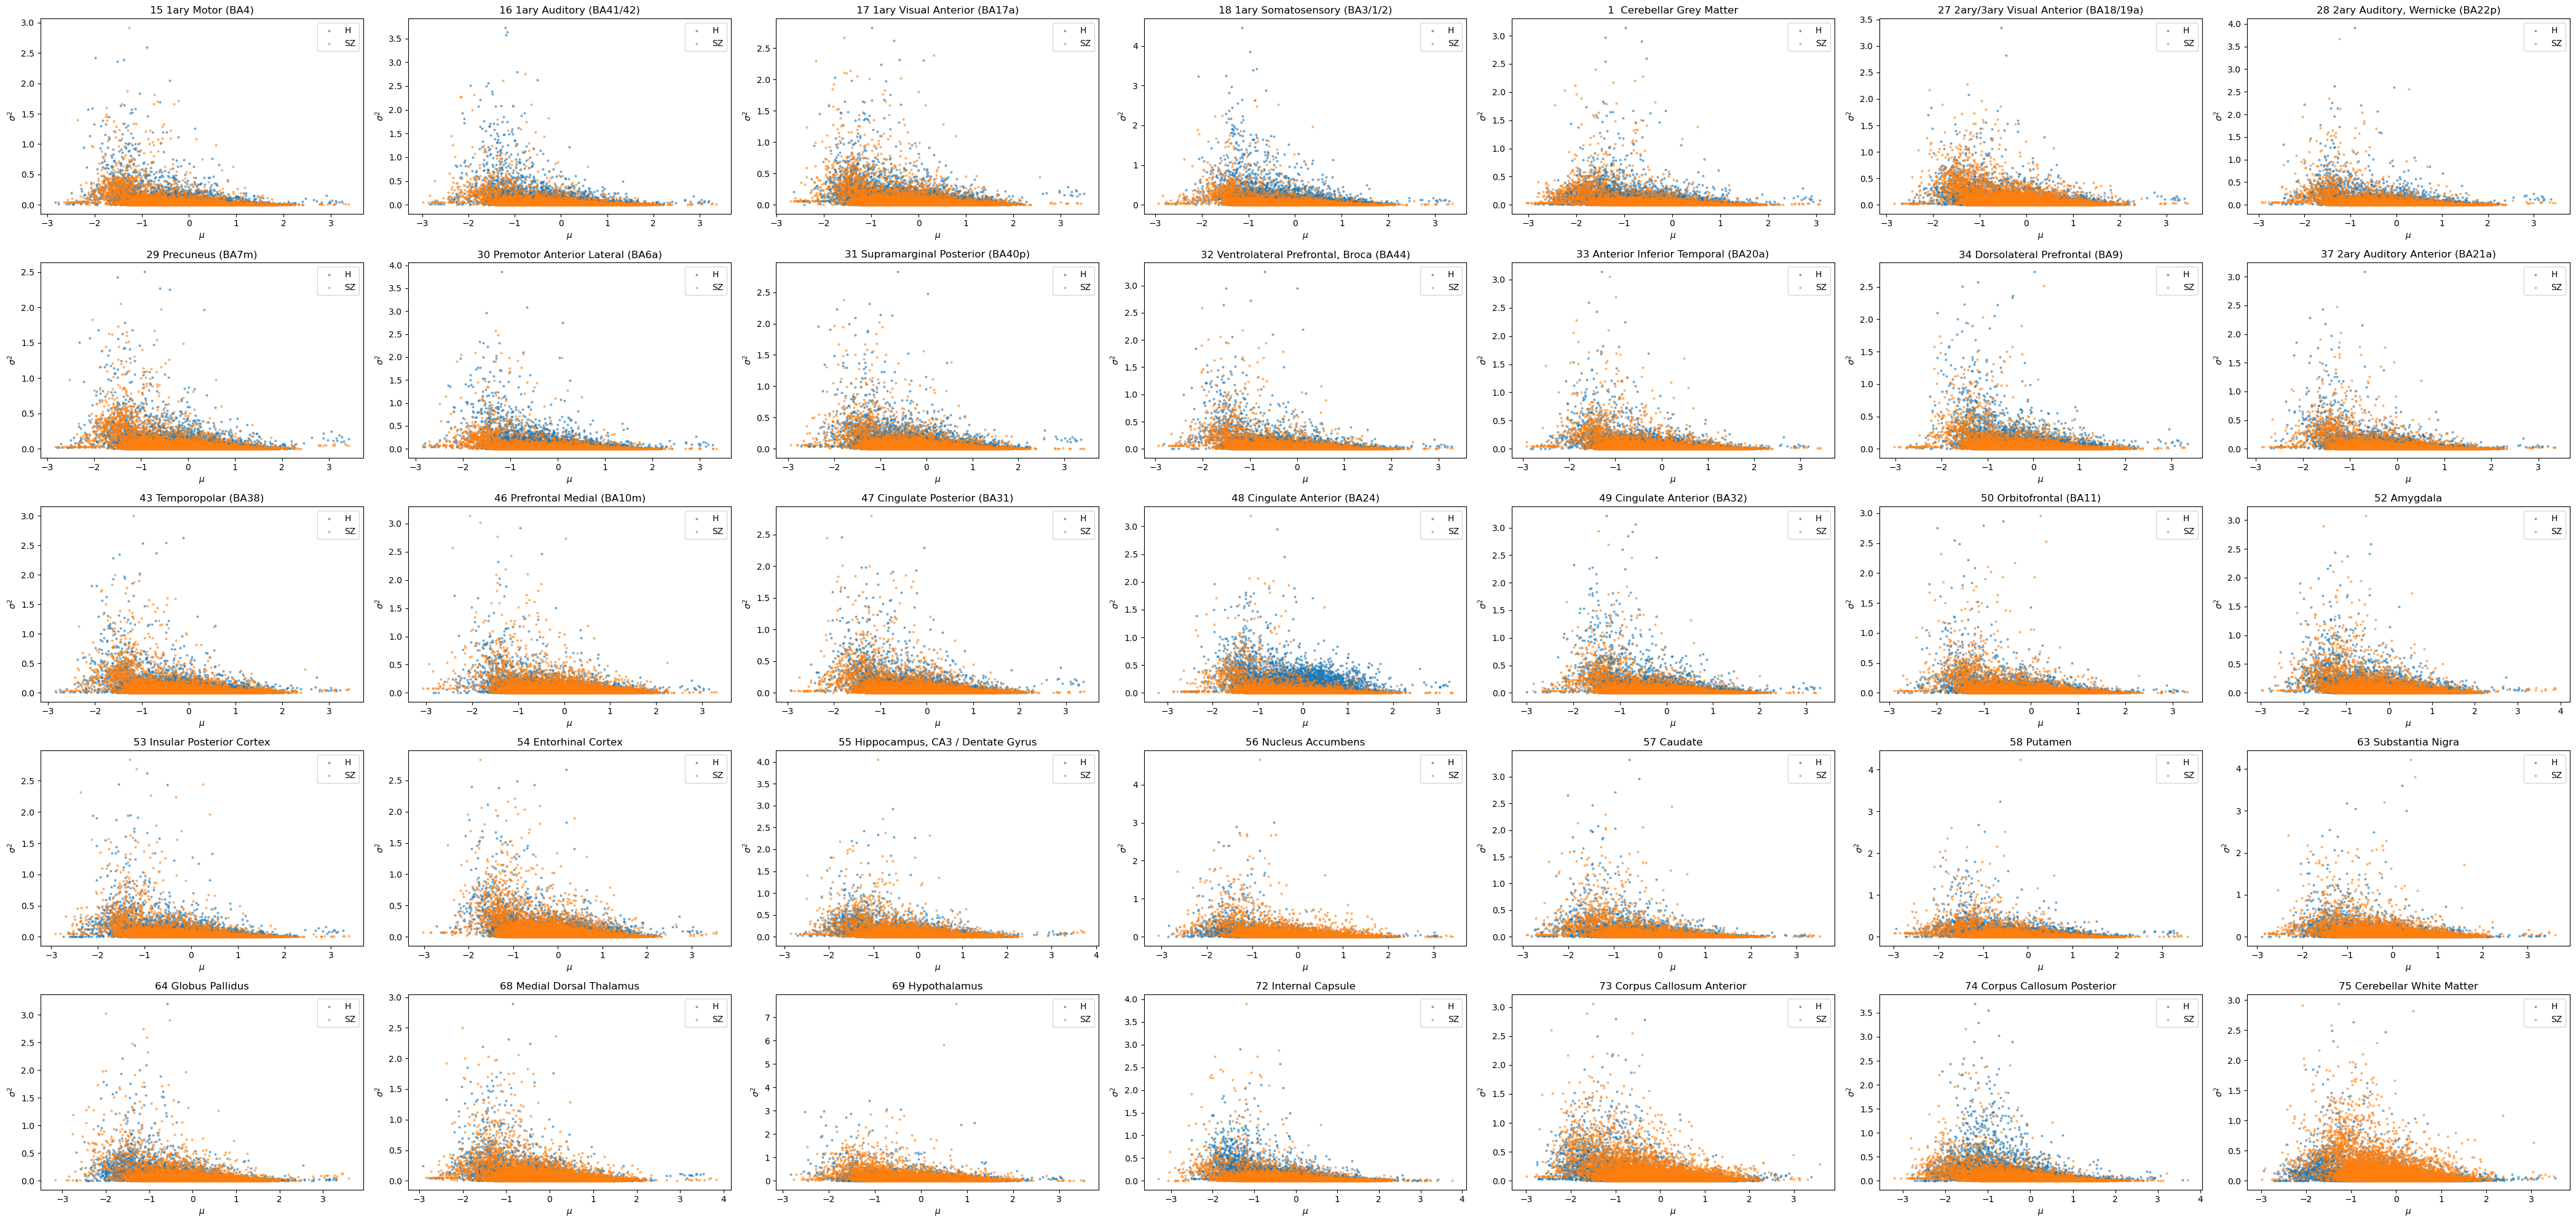

In [9]:
nrows = 5
ncols = 7
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*4))
axs = axs.flatten()
for i, region_nm in enumerate(sz_data.region.unique()):
    ax = axs[i]
    h_region = healthy_data[healthy_data.region == region_nm].drop(columns=["batch", "region"])
    sz_region = sz_data[sz_data.region == region_nm].drop(columns=["batch", "region"])

    h_means = h_region.mean(axis=0).values
    h_sigma_sq = h_region.var(axis=0).values

    sz_means = sz_region.mean(axis=0).values
    sz_sigma_sq = sz_region.var(axis=0).values

    ax.scatter(h_means, h_sigma_sq, s=2**2, alpha=.5, label="H")
    ax.scatter(sz_means, sz_sigma_sq, s=2**2, alpha=.5, label="SZ")
    
    ax.set_title(region_nm)
    ax.set_xlabel("$\mu$")
    ax.set_ylabel("$\sigma^2$")
    ax.legend()
    
plt.tight_layout()    
plt.savefig("../../data/intermediate/pics/fig3.pdf", dpi=200)

In [10]:
h_region

ENSG00000000003  ENSG00000000419  ENSG00000000457  ENSG00000000460  \
human                                                                       
HA            0.054305         0.074054        -0.375253        -0.719247   
HB           -0.466023         0.142739        -0.611973        -0.731999   
HC           -0.345528         0.177391        -0.805608        -0.612306   
HD           -0.281398         0.229932        -0.419867        -0.862693   

       ENSG00000000938  ENSG00000000971  ENSG00000001036  ENSG00000001084  \
human                                                                       
HA           -0.501636        -0.011871         0.576905         0.392203   
HB           -0.030196        -0.237110         0.560699         0.532183   
HC            0.133309         0.289169         0.353055         0.405407   
HD           -0.230884        -0.174328         0.588960         0.610628   

       ENSG00000001167  ENSG00000001460  ...  ENSG00000284194  \
human                                    ...                    
HA           -0.207798        -0.100319  ...        -0.763832   
HB           -0.275723         0.065257  ...        -0.568309   
HC           -0.115058        -0.060029  ...        -0.271329   
HD           -0.371254        -0.021706  ...        -0.826789   

       ENSG00000284292  ENSG00000284308  ENSG00000284341  ENSG00000284461  \
human                                                                       
HA           -0.445926        -0.317655        -0.554126        -0.078915   
HB           -0.288706        -0.229752        -2.147749         0.075650   
HC           -0.457278        -0.580930        -2.304662        -0.189168   
HD           -1.353639        -0.117747        -0.255554         0.200633   

       ENSG00000284479  ENSG00000284505  ENSG00000284512  ENSG00000284526  \
human                                                                       
HA           -0.344768        -0.590568        -0.957118        -1.754983   
HB           -1.084519        -1.128674        -0.400204        -1.674460   
HC           -0.697363        -0.672802        -1.061390        -1.321458   
HD           -1.116603        -0.729394        -0.825863        -0.565925   

       ENSG00000284691  
human                   
HA           -0.366727  
HB           -0.378766  
HC            0.006246  
HD           -0.271188  

[4 rows x 15013 columns]

In [11]:
from sklearn.cluster import DBSCAN

In [12]:
dbscan = DBSCAN(n_jobs=-1)

In [13]:
y = dbscan.fit_predict(h_region.T)

In [14]:
pd.Series(y).value_counts()

 0    14906
-1      107
dtype: int64

In [50]:
h_lipid = pd.read_csv("../../data/input/rtmz_H_pos_std_weight_norm_TL_COMBINED.csv", index_col=0).reset_index(names="Sample")
sz_lipid = pd.read_csv("../../data/input/rtmz_SZ_pos_std_weight_norm_TL_COMBINED.csv", index_col=0).reset_index(names="Sample")
meta = pd.read_csv("../../data/input/meta_pos_COMBINED.csv", index_col=0)
meta.Sample = meta.Sample.str.rstrip(".mzXML")
h_lipid.Sample = h_lipid.Sample.str.rstrip(".mzXML")
sz_lipid.Sample = sz_lipid.Sample.str.rstrip(".mzXML")

h_lipid = pd.merge(meta[["Sample", "Region_detailed", "Brain_abbr"]], h_lipid, on="Sample")
sz_lipid = pd.merge(meta[["Sample", "Region_detailed", "Brain_abbr"]], sz_lipid, on="Sample")

print(h_lipid.shape, sz_lipid.shape)

(296, 382) (292, 382)


In [41]:
kfold = KFold(n_splits=8)
logregcv = LogisticRegressionCV(Cs=np.logspace(-1, 3), cv=kfold, n_jobs=-1, random_state=4329809)

X = pd.concat([h_region, sz_region]).dropna(axis=1).values

y = [0, 0, 0, 0, 1, 1, 1, 1]

logregcv.fit(X, y)

logregcv.C_

logregcv.scores_

{1: array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 

# stattests

In [6]:
common_genes = list(set(healthy_data.columns) & set(sz_data.columns) - set(["region", "batch"]))
A = healthy_data.groupby("region")[common_genes].apply(pd.Series.tolist).tolist()
A = np.array(A)
B = sz_data.groupby("region")[common_genes].apply(pd.Series.tolist).tolist()
B = np.array(B)
ttest = ttest_ind(A, B, axis=1)

In [7]:
p_vals_corrected = multipletests(ttest.pvalue.reshape(-1,), alpha=0.05, method="holm-sidak")
p_vals_corrected = p_vals_corrected[1].reshape(35,-1)

In [8]:
p_vals_corrected = pd.DataFrame(p_vals_corrected, index=healthy_data.region.unique(), columns=common_genes)

In [9]:
genes = p_vals_corrected[p_vals_corrected < .05].stack()

In [10]:
genes

1  Cerebellar Grey Matter              ENSG00000173166    0.005742
15 1ary Motor (BA4)                    ENSG00000025772    0.002790
28 2ary Auditory, Wernicke (BA22p)     ENSG00000008441    0.021120
33 Anterior Inferior Temporal (BA20a)  ENSG00000115966    0.048291
                                       ENSG00000169967    0.048344
34 Dorsolateral Prefrontal (BA9)       ENSG00000080371    0.026713
52 Amygdala                            ENSG00000085224    0.032036
                                       ENSG00000048649    0.036455
56 Nucleus Accumbens                   ENSG00000106636    0.011221
                                       ENSG00000085224    0.004179
                                       ENSG00000038219    0.040155
                                       ENSG00000102908    0.008513
                                       ENSG00000127914    0.009514
57 Caudate                             ENSG00000198162    0.032574
63 Substantia Nigra                    ENSG00000089048    0.01

In [11]:
print("\n".join(np.array(genes.index.tolist())[:, 1].tolist()))

ENSG00000173166
ENSG00000025772
ENSG00000008441
ENSG00000115966
ENSG00000169967
ENSG00000080371
ENSG00000085224
ENSG00000048649
ENSG00000106636
ENSG00000085224
ENSG00000038219
ENSG00000102908
ENSG00000127914
ENSG00000198162
ENSG00000089048
ENSG00000129534


# region prediction

In [12]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

y = encoder.fit_transform(healthy_data.region)
y = np.concatenate([y, encoder.transform(sz_data.region)])

X = np.concatenate([healthy_data[common_genes].values, sz_data[common_genes].values])
n_splits = 5
kfold = KFold(n_splits=n_splits)
print(X.shape, y.shape)
means = X.mean(axis=0)
sigma = X.std(axis=0)
X = (X - means) / sigma

(280, 14177) (280,)


In [31]:
model = LogisticRegression(
    solver="saga",
    penalty="elasticnet",
    C=10,
    l1_ratio=.5,
    max_iter=200,
    n_jobs=-1,
    random_state=8327647
)

model = RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=-1, random_state=329876)

metric = 0
for train_idx, test_idx in tqdm(kfold.split(X, y)):
    X_train = X[train_idx]
    X_test = X[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
#     y_pred = np.random.randint(35, size=y_test.shape)
    metric += accuracy_score(y_pred, y_test)
metric /= n_splits
print(metric)

5it [00:02,  1.86it/s]

0.2857142857142857


In [15]:
gridsearch = GridSearchCV(
    estimator=RandomForestClassifier(n_jobs=-1, random_state=1298643),
    cv=KFold(n_splits=280),
    param_grid={
        "n_estimators": [200, 300], "criterion": ["gini", "entropy"],
        "max_depth": np.arange(30, 50, 4),
        "max_features": ["sqrt", "log2"],
    },
    scoring="accuracy",
    verbose=2,
)

In [16]:
gridsearch.fit(X, y)

Fitting 280 folds for each of 40 candidates, totalling 11200 fits
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   4.0s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.8s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.7s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; tot

[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=30, max_feature

[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=30, max_feature

[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.7s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.7s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.8s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.8s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.8s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=200; total time=   2.7s
[CV] END criterion=gini, max_depth=30, max_feature

[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   3.6s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   3.8s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   3.6s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   3.6s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   3.6s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   3.6s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   3.8s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=30, max_feature

[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   4.2s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   4.3s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   4.2s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=30, max_feature

[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   4.8s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   4.3s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   4.2s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   4.3s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   4.2s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   4.2s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, n_estimators=300; total time=   4.2s
[CV] END criterion=gini, max_depth=30, max_feature

[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=30, max_feature

[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.8s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=30, max_feature

[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.8s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=30, max_feature

[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   1.1s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=gini, max_depth=30, max_feature

[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   1.3s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   1.1s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   1.1s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=gini, max_depth=30, max_feature

[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=30, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=30, max_feature

[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.4s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=34, max_feature

[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.4s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   3.0s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=34, max_feature

[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=34, max_feature

[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   3.7s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   3.3s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   3.1s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   3.1s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.7s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.7s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   3.1s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=200; total time=   3.0s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.2s
[CV] END criterion=gini, max_depth=34, max_feature

[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.0s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.0s
[CV] END criterion=gini, max_depth=34, max_feature

[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.3s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.2s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.3s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.3s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.2s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.2s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=34, max_feature

[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.2s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.2s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.2s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=34, max_features=sqrt, n_estimators=300; total time=   4.1s
[CV] END criterion=gini, max_depth=34, max_feature

[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=34, max_feature

[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.7s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=34, max_feature

[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=34, max_feature

[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=34, max_feature

[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.7s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=34, max_feature

[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=34, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=34, max_feature

[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=38, max_feature

[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=38, max_feature

[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   3.0s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.9s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=38, max_feature

[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.8s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_feature

[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.6s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_feature

[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.8s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.8s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.8s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.8s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.8s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.8s
[CV] END criterion=gini, max_depth=38, max_feature

[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.8s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.6s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=38, max_feature

[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.5s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.5s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=38, max_feature

[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=38, max_feature

[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.5s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.5s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=38, max_feature

[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=38, max_feature

[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=38, max_feature

[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=38, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=38, max_feature

[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=42, max_feature

[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=42, max_feature

[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=42, max_feature

[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.6s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_feature

[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_feature

[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.8s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_feature

[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_feature

[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_feature

[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_feature

[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.5s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=200; total time=   0.5s
[CV] END criterion=gini, max_depth=42, max_feature

[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.7s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=42, max_feature

[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.7s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.7s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.7s
[CV] END criterion=gini, max_depth=42, max_feature

[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=42, max_features=log2, n_estimators=300; total time=   0.7s
[CV] END criterion=gini, max_depth=42, max_feature

[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=46, max_feature

[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=46, max_feature

[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=200; total time=   2.6s
[CV] END criterion=gini, max_depth=46, max_feature

[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.6s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.6s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=46, max_feature

[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=46, max_feature

[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.8s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.8s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.6s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.8s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=46, max_features=sqrt, n_estimators=300; total time=   3.7s
[CV] END criterion=gini, max_depth=46, max_feature

[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_feature

[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.5s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_feature

[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_feature

[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=46, max_feature

[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=46, max_feature

[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.7s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.7s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=46, max_feature

[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=46, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=gini, max_depth=46, max_feature

[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.6s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   6.3s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.2s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.2s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=30, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.6s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.9s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.2s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   7.9s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=34, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.3s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=34, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   7.9s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   7.9s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=38, max_features=sqrt, n_estimators=300; total time=   7.8s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=38, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.6s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.6s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.2s
[CV] END criterion=entropy, max_depth=42, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.6s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.3s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=42, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.6s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.6s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.5s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=200; total time=   5.4s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.2s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.2s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.0s
[CV] END criterion=entropy, max_depth=46, max_features=sqrt, n_estimators=300; total time=   8.1s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=200; total time=   1.0s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.4s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=e

[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.5s
[CV] END criterion=entropy, max_depth=46, max_features=log2, n_estimators=300; total time=   1.5s


GridSearchCV(cv=KFold(n_splits=280, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=1298643),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([30, 34, 38, 42, 46]),
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 300]},
             scoring='accuracy', verbose=2)

In [17]:
gridsearch.best_score_

0.2357142857142857

In [18]:
gridsearch.best_params_

{'criterion': 'entropy',
 'max_depth': 30,
 'max_features': 'sqrt',
 'n_estimators': 300}

In [19]:
import pickle

In [20]:
with open("../../data/intermediate/gridsearch_RF.pkl", "wb") as fout:
    pickle.dump(gridsearch, fout)